# Multi-Class Text Classification with BERT

In [1]:
import os
import json
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig, AdamW

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pyplot import figure

%matplotlib inline

RANDOM_SEED = 123

pl.seed_everything(RANDOM_SEED)
pd.options.display.max_colwidth = 100

Global seed set to 123


In [2]:
# Require to change: 
parent_dir = '/intentidentification/task-specific-datasets/banking_data/'
train_path = parent_dir + 'train.csv'
test_path = parent_dir + 'test.csv'
logging_path = 'lightning_logs_banking_temp'
checkpoint_path = 'checkpoints_banking_temp'
BERT_MODEL_NAME = 'bert-base-cased'
MAX_TOKEN_COUNT = 300
N_EPOCHS = 40
BATCH_SIZE = 16

## Data Processing

In [3]:
# Reading csv and shuffling them
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

Let's take a look at the dataset

In [4]:
df_train[5:10]

,text,category
7339,How can I receive money?,receiving_money
3662,where can I change my address?,edit_personal_details
7,What do I do if I still have not received my new card?,card_arrival
3096,Is there anywhere I can't use my card?,card_acceptance
890,I want to have multiple currencies in my account if possible.,fiat_currency_support


In [ ]:
print(df_train['category'].value_counts())

In [5]:
possible_labels = df_train['category'].unique()
LABEL_COLUMNS = possible_labels

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: category, Length: 77, dtype: int64


{'card_delivery_estimate': 0,
 'cash_withdrawal_charge': 1,
 'balance_not_updated_after_cheque_or_cash_deposit': 2,
 'receiving_money': 3,
 'edit_personal_details': 4,
 'card_arrival': 5,
 'card_acceptance': 6,
 'fiat_currency_support': 7,
 'declined_cash_withdrawal': 8,
 'country_support': 9,
 'topping_up_by_card': 10,
 'wrong_exchange_rate_for_cash_withdrawal': 11,
 'Refund_not_showing_up': 12,
 'getting_virtual_card': 13,
 'visa_or_mastercard': 14,
 'balance_not_updated_after_bank_transfer': 15,
 'automatic_top_up': 16,
 'age_limit': 17,
 'transfer_fee_charged': 18,
 'card_not_working': 19,
 'lost_or_stolen_phone': 20,
 'verify_source_of_funds': 21,
 'card_about_to_expire': 22,
 'verify_top_up': 23,
 'top_up_reverted': 24,
 'pending_top_up': 25,
 'top_up_failed': 26,
 'card_payment_fee_charged': 27,
 'atm_support': 28,
 'pending_cash_withdrawal': 29,
 'pending_card_payment': 30,
 'cancel_transfer': 31,
 'top_up_by_cash_or_cheque': 32,
 'getting_spare_card': 33,
 'request_refund': 34

In [6]:
df_train['label'] = df_train['category'].replace(label_dict)
df_test['label'] = df_test['category'].replace(label_dict)
df_train

,text,category,label
1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,0
9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,1
9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was cha...,cash_withdrawal_charge,1
3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please ...,balance_not_updated_after_cheque_or_cash_deposit,2
7402,Are there ways for other people to send me money?,receiving_money,3
...,...,...,...
9785,What documents are required for proof of identity?,verify_my_identity,59
7763,Please tell me how to verify my top up card.,verify_top_up,23
5218,I have a payment that is still pending,pending_card_payment,30
1346,I need clarity on why my card is not working.,card_not_working,19


In [11]:
train_df, val_df = train_test_split(df_train, test_size=0.05)
test_df = df_test

### Tokenization


In [13]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [14]:
sample_row = train_df.iloc[15]
sample_comment = sample_row.text
sample_labels = sample_row.category

print(sample_comment)
print(sample_labels)

I didn't realize that there were any fees for withdrawing money from my account--this has never happened to me before.  What exactly are the fees?
cash_withdrawal_charge


In [15]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=300,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [16]:
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

torch.Size([1, 300]) torch.Size([1, 300])


In [17]:
print(encoding["input_ids"].squeeze()[:50])
print(encoding["attention_mask"].squeeze()[:50])

tensor([  101,   146,  1238,   112,   189,  4663,  1115,  1175,  1127,  1251,
         9942,  1111, 24749,  1948,  1121,  1139,  3300,   118,   118,  1142,
         1144,  1309,  2171,  1106,  1143,  1196,   119,  1327,  2839,  1132,
         1103,  9942,   136,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [18]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'I', 'didn', "'", 't', 'realize', 'that', 'there', 'were', 'any', 'fees', 'for', 'withdrawing', 'money', 'from', 'my', 'account', '-', '-', 'this']


98


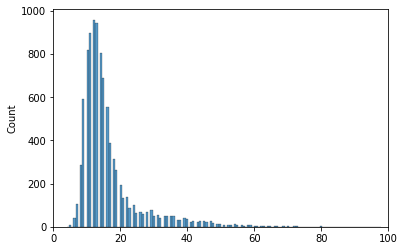

In [19]:
# Distribution of the tokenized sentences
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

sns.histplot(token_counts)
print(max(token_counts))
plt.xlim([0, 100]);

### Dataset

In [20]:
class Generic_Dataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row.label

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor(labels)
    )

In [21]:
train_dataset = Generic_Dataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [22]:
print(sample_item["comment_text"])
print(sample_item["labels"])
print(sample_item["input_ids"].shape)

My refund has not shown up on my statement.
tensor(12)
torch.Size([300])


In [23]:
class Generic_DataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = Generic_Dataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = Generic_Dataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [24]:
data_module = Generic_DataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

In [25]:
class Tagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.config = BertConfig.from_pretrained(BERT_MODEL_NAME, num_labels=n_classes, return_dict=True)
    self.bert = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, config=self.config)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask, labels=labels)
    return output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss
    y_hat = outputs.logits
#     print(loss)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss
    y_hat = outputs.logits
    _, y_hat = torch.max(y_hat, dim=1)
    val_acc = accuracy_score(y_hat.cpu(), labels.cpu())
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    outputs = self(input_ids, attention_mask)
    loss = outputs.loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
  )

In [26]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(4744, 23720)

In [27]:
# Create an instance of the model
model = Tagger(
  n_classes=77,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Training

In [28]:
!rm -rf logging_path/
!rm -rf checkpoint_path/

%load_ext tensorboard
%tensorboard --logdir ./logging_path

Reusing TensorBoard on port 6006 (pid 32402), started 3 days, 15:52:12 ago. (Use '!kill 32402' to kill it.)

In [29]:
checkpoint_callback = ModelCheckpoint(
  dirpath=checkpoint_path,
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints_banking_temp exists and is not empty.
  warnings.warn(*args, **kwargs)


In [30]:
logger = TensorBoardLogger(logging_path, name="classification")

In [31]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [32]:
# Training
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [33]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 108 M 
-------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.478   Total estimated model params size (MB)
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 593: val_loss reached 4.18714 (best 4.18714), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1187: val_loss reached 3.12827 (best 3.12827), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1781: val_loss reached 2.03241 (best 2.03241), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 2375: val_loss reached 1.21702 (best 1.21702), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 2969: val_loss reached 0.74847 (best 0.74847), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 3563: val_loss reached 0.52207 (best 0.52207), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 4157: val_loss reached 0.46752 (best 0.46752), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 4751: val_loss reached 0.40244 (best 0.40244), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_banking_temp/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, step 5345: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, step 5939: val_loss was not in top 1


1

In [45]:
torch.save(model.state_dict(), 'banking_saved.bin')

## Predictions

In [35]:
trained_model = Tagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Evaluation

In [37]:
THRESHOLD = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = Generic_Dataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device),
    item["labels"].unsqueeze(dim=0).to(device)
    )
    predictions.append(torch.max(prediction.logits, dim=1).indices.int()[0])
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3080 [00:00<?, ?it/s]

In [39]:
accuracy(predictions, labels)

tensor(0.9185)

In [44]:
y_pred = predictions.numpy().copy()
y_true = labels.numpy().copy()

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

                                                  precision    recall  f1-score   support

                          card_delivery_estimate       0.90      0.88      0.89        40
                          cash_withdrawal_charge       0.95      0.95      0.95        40
balance_not_updated_after_cheque_or_cash_deposit       0.95      0.93      0.94        40
                                 receiving_money       0.95      0.93      0.94        40
                           edit_personal_details       1.00      1.00      1.00        40
                                    card_arrival       0.92      0.88      0.90        40
                                 card_acceptance       0.97      0.85      0.91        40
                           fiat_currency_support       0.94      0.82      0.88        40
                        declined_cash_withdrawal       0.83      0.97      0.90        40
                                 country_support       0.91      1.00      0.95        40
         